# Identifying Forest Fires Images Using Deep Learning

# Introduction

Areas that are are covered by forest and woodlands are increasingly threatened by natural disasters such as wildfires. The magnitude and the frequecny of these wildfires are becoming more harmful for the inhabitants and the people who are living around these areas.

In this project, we will create Deep learning model that can classify images that have fire or do not have fire in them. These would help minimize the impact of the peopleand nature which would be an early prevention tool and a allow officials to have quicker response time for evacuation if need be.


First step is to import our libraries


In [ ]:
#import our library that we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from  keras.utils import plot_model
import cv2
import glob
from functools import partial

The data images are split into two folders, training data and testing data. In both they are futher split into two other folders "fire" and "non-fire".

The training data contains 5000 images, 2500 of which are "fire" and 2500 of which are "non-fire". The testing set contains 50 images in total with 25 in the "fire" and the remaining 25 in the "non-fire" folder.


We will first mount the folder in a google drive so we can access the data before we proprocess the data.

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing Data


Now that we have the images at hand, we proceed to extract those images from their respected folders.

This is done by reading the file and saving the images, then clean the data. We noticed that some images in the training data contain no images. This was done by checking the number of the index of the image and then checking what was the name of the folder using iterative loops. Once we knew that the file was empty, we then proceeded to remove those images that were given as "NONE".

Once the data had been cleaned, we also found out that the sizes of the images where different. Therefore, we resized them to all to 224 by 224. We also tried smaller sizes such as 28x28 images but the information in the images where lost and it looked pixelated.

In [ ]:
#Read and save images to respected category
Train_data_fire = [cv2.imread(file)
 for file in glob.glob("/content/drive/MyDrive/Data/Train_Data/Fire/*.jpg")]
Train_data_nonfire = [cv2.imread(file)
 for file in glob.glob("/content/drive/MyDrive/Data/Train_Data/Non_Fire/*.jpg")]
Test_data_fire = [cv2.imread(file)
 for file in glob.glob("/content/drive/MyDrive/Data/Test_Data/Fire/*.jpg")]
Test_data_nonfire = [cv2.imread(file)
 for file in glob.glob("/content/drive/MyDrive/Data/Test_Data/Non_Fire/*.jpg")]

#clean the data by removing the None images
Train_data_fire_cleaned = [img for
                           img in Train_data_fire if img is not None]
Train_data_nonfire_cleaned = [img for
                              img in Train_data_nonfire if img is not None]
Test_data_fire_cleaned = [img for
                          img in Test_data_fire if img is not None]
Test_data_nonfire_cleaned = [img for
                             img in Test_data_nonfire if img is not None]

#this resizes all the images,
for i in range(len(Train_data_fire_cleaned)):
  Train_data_fire_cleaned[i] = cv2.resize(Train_data_fire_cleaned[i],(224,224))

for i in range(len(Train_data_nonfire_cleaned)):
  Train_data_nonfire_cleaned[i] = cv2.resize(Train_data_nonfire_cleaned[i],
   (224,224))

for i in range(len(Test_data_fire_cleaned)):
  Test_data_fire_cleaned[i] = cv2.resize(Test_data_fire_cleaned[i],(224,224))
  Test_data_nonfire_cleaned[i] = cv2.resize(Test_data_nonfire_cleaned[i],
   (224,224))

The colour is one of the most important aspect of the data since the bright red colour indicated fire, leading to us not using a greyscale theme. Note that the conversion is from BRG to RGB, because the default of the cv2.images function are BRG. We then finish the preprocessing step by converting them into a numpy array, allowing us to check the dimension of both the training and testing data.

In [ ]:
# Convert images to colour RGB
Train_data_fire_cleaned_colour = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 for img in Train_data_fire_cleaned]
Train_data_nonfire_cleaned_colour = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for img in Train_data_nonfire_cleaned]
Test_data_fire_cleaned_colour = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for img in Test_data_fire_cleaned]
Test_data_nonfire_cleaned_colour = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for img in Test_data_nonfire_cleaned]

# Convert lists to numpy arrays
Train_data_fire_cleaned_colour = np.array(Train_data_fire_cleaned_colour)
Train_data_nonfire_cleaned_colour = np.array(Train_data_nonfire_cleaned_colour)
Test_data_fire_cleaned_colour = np.array(Test_data_fire_cleaned_colour)
Test_data_nonfire_cleaned_colour = np.array(Test_data_nonfire_cleaned_colour)

# Print the shapes of the arrays
print("The Training Data Fire set shape is:",
      Train_data_fire_cleaned_colour.shape)
print("The Training Data Non-Fire set shape is:",
      Train_data_nonfire_cleaned_colour.shape)
print("The Testing Data Fire set shape is:",
      Test_data_fire_cleaned_colour.shape)
print("The Testing Data Non-Fire set shape is:",
      Test_data_nonfire_cleaned_colour.shape)



The Training Data Fire set shape is: (2117, 224, 224, 3)
The Training Data Non-Fire set shape is: (2509, 224, 224, 3)
The Testing Data Fire set shape is: (25, 224, 224, 3)
The Testing Data Non-Fire set shape is: (25, 224, 224, 3)


We can also take a quick look at the images in the training data one is from the "fire" and the other is from the "non-fire" folder. This showed that we had preprocessed them as we wanted.

(224, 224, 3)


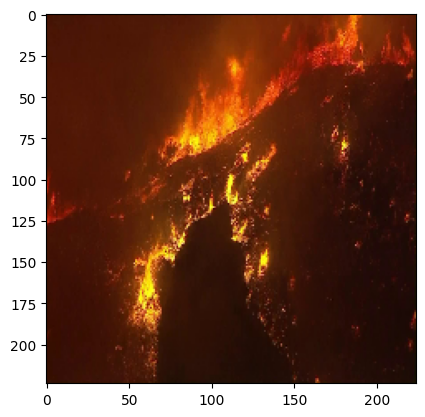

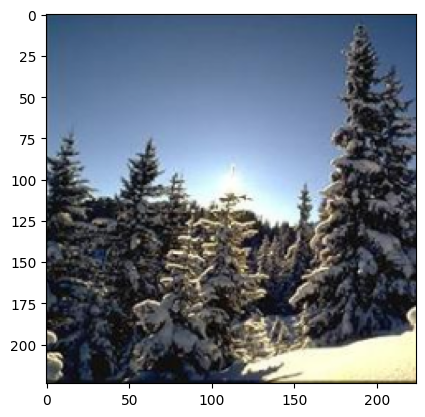

In [ ]:
#prints the image of shape
print(Train_data_fire_cleaned_colour[0].shape)
#shows the image  of a fire image
plt.imshow(Train_data_fire_cleaned_colour[0], vmin=0, vmax=255)
plt.show()
#shows the image of
plt.imshow(Train_data_nonfire_cleaned_colour[0], vmin=0, vmax=255)
plt.show()


# Train,Test and Valid split

We began by creating four training set and testing set arrays. This was done by having the "fire" and "non-fire" images into the "X_train_full" array and the corresponding labels of "1" meaning "fire" and "0" meaning "non-fire" into the "y_train_full" array. This was repeated for the testing set array.

Notice that we shuffle the indices of the "X_train_full" variable as we want to have a consistent way to identify their labels in the target grooup in "y_train_full". The test data remains the same and unchanged.


The "X_train_full" and y_train_full" training data is used to create the validation set. For the validation set we have the same number of images as the testing set which is 50. We also standarise the pixel intesity of the validation and the training sets by a ratio of 255.


In [ ]:
#The training and testing set is added together
X_train_full = np.concatenate((Train_data_fire_cleaned_colour,
                               Train_data_nonfire_cleaned_colour))
y_train_full = np.array([1]*len(Train_data_fire_cleaned_colour) +
 [0]*len(Train_data_nonfire_cleaned_colour))
X_test = np.concatenate((Test_data_fire_cleaned_colour,
                         Test_data_nonfire_cleaned_colour))
y_test = np.array([1]*len(Test_data_fire_cleaned_colour) +
 [0]*len(Test_data_nonfire_cleaned_colour))

# Shuffle X_train_full and y_train_full in a consistent way
# Create indices to shuffle
indices = np.arange(X_train_full.shape[0])
np.random.shuffle(indices)

# Apply shuffling using the same indices
X_train_full = X_train_full[indices]
y_train_full = y_train_full[indices]

#create the labels
labels = {
    0: 'Non-Fire',
    1: 'Fire'
}
#check labels
print(labels[y_train_full[4500]])


#Validation set
X_valid, X_train = X_train_full[:50]/255.0, X_train_full[50:]/255.0
y_valid, y_train = y_train_full[:50], y_train_full[50:]

#print shapes
print("The dimensions of,")
print("Training set, X_train:",X_train.shape," y_train: ",y_train.shape)
print("Validation set, X_valid:",X_valid.shape," y_valid: ",y_valid.shape)
print("Testing set, X_test:",X_test.shape," y_test: ",y_test.shape)

Fire
The dimensions of,
Training set, X_train: (4576, 224, 224, 3)  y_train:  (4576,)
Validation set, X_valid: (50, 224, 224, 3)  y_valid:  (50,)
Testing set, X_test: (50, 224, 224, 3)  y_test:  (50,)


# Simple neural network


We start our deep learning model with a simple neural network using a Sequential API model.
We first flatten the first layer, this converts each image into a 1D array. Meaning that our 4D input array gets rehaped into a 1D. This has no parameters [1].

We explored many different number of hidden layers such as one, two or three concluding that two hidden layers had the most optimal loss and accuracy. We also explored the number of neurons ranging from 100 to 300, and having different number of neurons in the two hidden layers. However, the best was to use the same number of 300 neurons in both layers[1]. This provides the most flexibilty to fit the training data images [1].

The activation of "relu", "selu" and "elu" were all explored and the best activation result came from the "relu". The "selu" and "elu" both had similiar losses and but a low accuracy compared to the "relu".

The outer activation was between the "sigmoid" and the "softmax" which the "sigmoid" produced the best results.

The ultimate goal of our model is to detect if the image contains fire or not, making this a binary classification. This meant we had look at this as having one or two outer neurons.
For the binary classification, we used the one neuron which only resulted in producing one element "0" which was "non-fire". Leading to us using the two outer neurons.
Therefore our simple model was produced.

The summary of the simple sequential model shows that we have 150528 neurons that have been flattened to 1-D. Then put this through our first hidden layer of 300 neurons which givens us 45 million parameters, then through the second hidden layer which has 90,300 paramters and finally produces one of the 2 labels needed with 602 parameters. The total number of paramters are 19598702 which is the same as the the trainable parameters.



In [ ]:
#the model is built
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[224, 224,3]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(2, activation="sigmoid")
])
#Summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 300)               45158700  
                                                                 
 dense_1 (Dense)             (None, 300)               90300     
                                                                 
 dense_2 (Dense)             (None, 2)                 602       
                                                                 
Total params: 45249602 (172.61 MB)
Trainable params: 45249602 (172.61 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We also can see the dimensions of the weights and the biases in the two hidden layer.

In [ ]:
#Shape of the weights and biases of hidden layer 1
ws, bs = model.layers[1].get_weights()
print("hidden1: weights:", ws.shape,"biases:",bs.shape)

#Shape of the weights and biases of hidden layer 2
ws2, bs2 = model.layers[2].get_weights()
print("hidden2: weights:", ws2.shape,"biases:",bs2.shape)


hidden1: weights: (150528, 300) biases: (300,)
hidden2: weights: (300, 300) biases: (300,)




We now look towards the Loss Function and the optimizer.

The loss functions that had the best evaluation was two neurons this used the "sparse categorical cross entropy" function. Using the sparse labels meant for each instance there was a class index, and for our model that is 0 or 1 [1]. Which further supports the use of the "sigmoid activiation" in the outer layer [1].
We also use the accuracy metric, to evalutate our model.

The optimiser used for now is Stochatic Gradient Descent (SGD), with a default learning rate of 0.01 and a momentum of 0.

We fit out model with the training set and validation set. The training loop (epoch) is set to 30, which minimizes the loss and tunes the weights.

We can also evaluate the the training set and the validation set by looking at their history, meaning that we ideally want a both the losses to steadily decrease and the accuracy to steadily increase.

Finally evaluating the model by using mean squared error of the testing set.

In [ ]:
#model is compiled
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer = keras.optimizers.SGD() ,
              metrics=["accuracy"])

#fit the model
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

#evaluate the model
mse_test = model.evaluate(X_test, y_test)

Epoch 1/30
143/143 [==============================] - 16s 106ms/step - loss: 0.6225 - accuracy: 0.7891 - val_loss: 0.3964 - val_accuracy: 0.8400
Epoch 2/30
143/143 [==============================] - 15s 104ms/step - loss: 0.3303 - accuracy: 0.8569 - val_loss: 0.3654 - val_accuracy: 0.8600
Epoch 3/30
143/143 [==============================] - 15s 103ms/step - loss: 0.3032 - accuracy: 0.8733 - val_loss: 0.2575 - val_accuracy: 0.9200
Epoch 4/30
143/143 [==============================] - 15s 105ms/step - loss: 0.2845 - accuracy: 0.8796 - val_loss: 0.2356 - val_accuracy: 0.9200
Epoch 5/30
143/143 [==============================] - 15s 107ms/step - loss: 0.2530 - accuracy: 0.8942 - val_loss: 0.3558 - val_accuracy: 0.8800
Epoch 6/30
143/143 [==============================] - 15s 107ms/step - loss: 0.2532 - accuracy: 0.8953 - val_loss: 0.2278 - val_accuracy: 0.9000
Epoch 7/30
143/143 [==============================] - 15s 103ms/step - loss: 0.2386 - accuracy: 0.8982 - val_loss: 0.4250 - val_ac

The simple neural network, produced a loss of 115.2 with an accuary score of 0.84, this is quite promising. These numbers are subject to change everytime the model is executed.

However, when we graph this we see that the loss and accuracy function is stable but the validation set is fluctuating in an unstable manner. This is an example of the vanishing gradient as we go down the layers the gradient becomes smaller and smaller. It could also show that we are overfitting the model. Therefore, we need to fine tuning hyperparameters such as, we start by first finding the best optimizers and their learining rates.









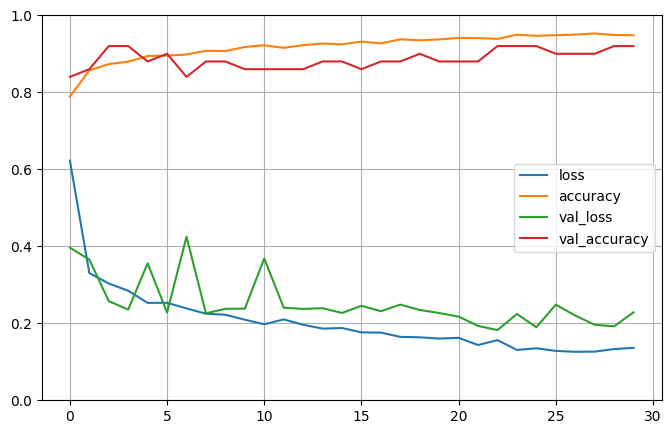

In [ ]:
  #plot the model
  pd.DataFrame(history.history).plot(figsize=(8, 5))
  plt.grid(True)
  plt.gca().set_ylim(0, 1)
  plt.show()


We see that some images are correctly labelled but some are not and this is shown by the evaluation  of the accuary being at 0.86 .


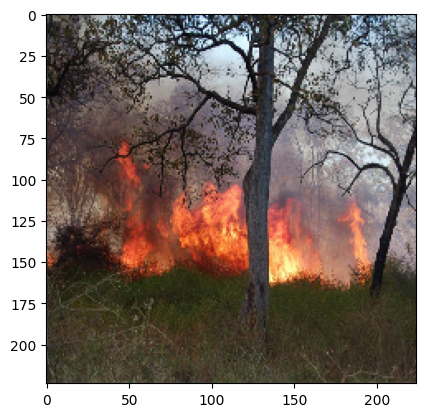

1/1 [==============================] - 0s 105ms/step
[1 1 1]
Fire


In [ ]:
#Show image and classification
X_new = X_test[:3]
plt.imshow(X_new[1], vmin=0, vmax=255)
plt.show()
y_pred = np.argmax(model.predict(X_new), axis=-1)
print(y_pred)
print(labels[y_pred[1]])

# Fine Tuning Hyperparameters


We start of by finding the best optimizer, this is a balance between loss and accuracy of the model thats evaluated.
All the learning rates and momentum remain constant throughout the processes. The five optimizers we will observe are the SDG, SDG with Nestrov, ADAM, RMS prop, and ADAgrad.


In [ ]:
def best_optimizer(name,model,optimizer):
  model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer = optimizer ,
              metrics=["accuracy"])
  print(name)
  history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid), verbose =0)
  mse_test = model.evaluate(X_test, y_test)
  print(mse_test)


#SGD
sgd = keras.optimizers.SGD(learning_rate=1e-3,momentum=0.9)
best_optimizer("SGD",model,sgd)

#SGD with Nestrov
sgd_nesterov = keras.optimizers.SGD(learning_rate=1e-3,momentum=0.9,
                                    nesterov=True)
best_optimizer("SGD Nesterov",model,sgd_nesterov)

#Adam
adam = keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999)
best_optimizer("Adam",model,adam)

#RMSprop
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-3, rho = 0.9)
best_optimizer("RMSprop",model,rmsprop)

#AdaGrad
ada = keras.optimizers.Adagrad(learning_rate=1e-3)
best_optimizer("AdaGrad",model,ada)



SGD
2/2 [==============================] - 0s 65ms/step - loss: 181.6209 - accuracy: 0.8600
[181.62094116210938, 0.8600000143051147]
SGD Nesterov
2/2 [==============================] - 0s 30ms/step - loss: 172.8540 - accuracy: 0.8600
[172.8539581298828, 0.8600000143051147]
Adam
2/2 [==============================] - 0s 24ms/step - loss: 109.3355 - accuracy: 0.7800
[109.33545684814453, 0.7799999713897705]
RMSprop
2/2 [==============================] - 0s 30ms/step - loss: 73.1420 - accuracy: 0.7400
[73.14202117919922, 0.7400000095367432]
AdaGrad
2/2 [==============================] - 0s 30ms/step - loss: 110.2129 - accuracy: 0.7400
[110.2128677368164, 0.7400000095367432]


The best optimizer for our model in terms of loss the "ADAM", we tried to  improve the accuracy as we fine tune the model but it was not close to the "SGD" which had the highest accuracy. The "RMSprop" has produced better results but at a more inconsistent rate.
Since the loss function is the predictabilty of our model, the error distance between the actual target and prediction, the lower the better and the accuracy is the correct classification of the images.

We also observe how the learning rates affect the model. We use three different learning rate of 0.01, 0.001 and 0.0001, the best was the 0.001.


# Normalisation

One way to combat the unstable gradient problem is using a normalisation technique, the two options we will explore are the HE-normalisation and Batch normalisation.

The He-normalisation is a techique that provides a proper flow in two direction [1]. The prediction made in the forward direction and the gradients of the backpropation in the reverse direction [1]. This is done by the variance output of each layers to be the same as the inputs and also the variance of the gradients must be equal in the backpropagation [1]. This is something which is very difficult so therfore we use randomly initialize the weight of each layer [1].


In [ ]:
#Only the He Normalisation
#Partial with the repeatable Dense Features
RegularizedDense = partial(
    keras.layers.Dense,
    activation="relu",
    kernel_initializer="he_normal",
    )

#the model is built
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[224, 224,3]),
    RegularizedDense(300),
    RegularizedDense(300),
    keras.layers.Dense(2, activation="sigmoid")
])
#Summary of model
model.summary()

#compile the model
model.compile(loss= keras.losses.SparseCategoricalCrossentropy(),
              optimizer = keras.optimizers.SGD(learning_rate=1e-3,
                                                     momentum=0.9),
              metrics=["accuracy"])

#fit the model
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

#evaluate the model
mse_test = model.evaluate(X_test, y_test)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_3 (Dense)             (None, 300)               45158700  
                                                                 
 dense_4 (Dense)             (None, 300)               90300     
                                                                 
 dense_5 (Dense)             (None, 2)                 602       
                                                                 
Total params: 45249602 (172.61 MB)
Trainable params: 45249602 (172.61 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
143/143 [==============================] - 22s 152ms/step - loss: 0.4539 - accuracy: 0.8195 - val_loss: 0.2781 - val_accuracy: 0.90

The He-normalisation has almost removed some the vanishing/ unstable gradient problem.
The evaluation of the model has also reduced the loss to 110.3 and increased the accuracy to 0.92. Therefore a need for batch normalisation.
This is shown in the plot below.

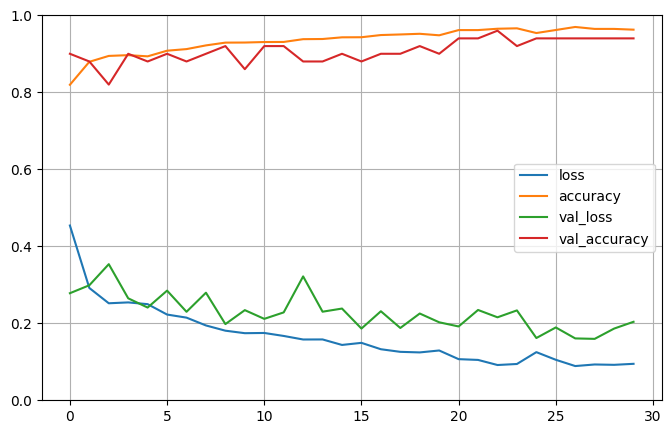

In [ ]:
#plot the model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Batch normalisation is used just incase the vanishing/unstable gradient appears during the training [1].
The Batch normalisation is used before each hidden layer by zero-centering and nomalisating each input, then scale and shift the result into two new parameters per layer [1].
The Batch normalisation lead to a high loss and low accuarcy and therefore removed.

The plot above shows using both He noramlisations reduces the vanishing/unstable gradient problem, but doesnt completely eliminate as it may appear later.

The Batch Normalisation did not improve our model. Also Gradient Clippling was looked into but this also didnt help either.
This could be a case of overfitting the model.

The image below has been classified correctly.

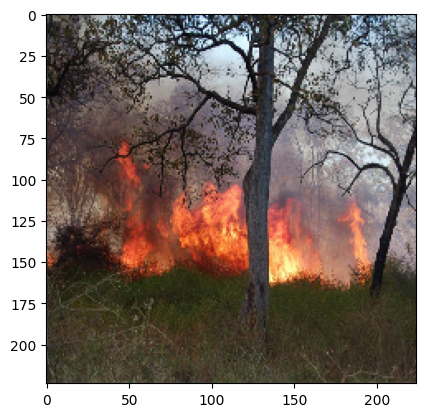

1/1 [==============================] - 0s 74ms/step
[1 1 1]
Fire


In [ ]:
#Show image and classification
X_new = X_test[:3]
plt.imshow(X_new[1], vmin=0, vmax=255)
plt.show()
y_pred = np.argmax(model.predict(X_new), axis=-1)
print(y_pred)
print(labels[y_pred[1]])

# Regularisation and Drop-outs

With all the fine tuning and addition of parameters, the models are very flexible with  a lot of freedom as seen in the model summaries above. This has lead to overfitting the model. One way of preventing this was to have a validation set and also having a large training set. However we are still overfitting. This is shown by the validation set suddenly flucuating.

Therefore we need to regularise them. This is done with two techniques, the first is L2 regularisation and the second is Dropouts.

Regularisation is adding an extra term to the loss fuction, using the sum of squares we have the L2 Regularisation. This rescales the weight to make them smaller.

In [ ]:
#L2 Regularisation
#Partial with the repeatable Dense Features
RegularizedDense = partial(
    keras.layers.Dense,
    activation="relu",
    kernel_initializer="he_normal",
    kernel_regularizer=keras.regularizers.l2(0.01),
    )
#the model is built
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[224, 224,3]),
    RegularizedDense(300),
    RegularizedDense(300),
    keras.layers.Dense(2, activation="sigmoid")
    ])
#Summary of model
model.summary()

#compile the model
model.compile(loss= keras.losses.SparseCategoricalCrossentropy(),
              optimizer =keras.optimizers.SGD(learning_rate=1e-3,
                                                     momentum=0.9),
              metrics=["accuracy"])

#fit the model
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

#evaluate the model
mse_test = model.evaluate(X_test, y_test)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_6 (Dense)             (None, 300)               45158700  
                                                                 
 dense_7 (Dense)             (None, 300)               90300     
                                                                 
 dense_8 (Dense)             (None, 2)                 602       
                                                                 
Total params: 45249602 (172.61 MB)
Trainable params: 45249602 (172.61 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
143/143 [==============================] - 28s 194ms/step - loss: 12.1104 - accuracy: 0.8298 - val_loss: 11.6075 - val_accuracy: 0.

The L2-regularisation has decreased the loss function to 100.5 and also decreased the accuracy to 0.86.

The graph below shows a stable validation loss and accuracy which is something we have been looking for.



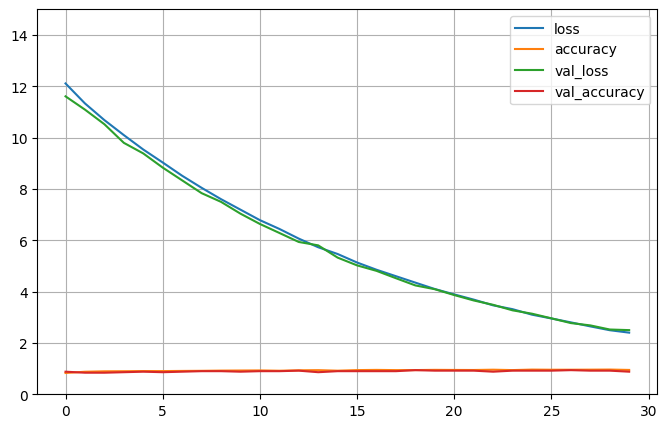

In [ ]:
#plot the model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 15)
plt.show()

Another method is to use Dropout to deal with the overfitting problem.

Dropout is a techique that modifies the model by removing the neurons in the network. This make the model more robust.
It uses the probability of randomly removing a neuron or "droppping Out" [1].


In [ ]:
#DropOut
#Partial with the repeatable Dense Features
RegularizedDense = partial(
    keras.layers.Dense,
    activation="relu",
    kernel_initializer="he_normal",
    )
#the model is built
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[224, 224,3]),
    keras.layers.Dropout(0.5),
    RegularizedDense(300),
    keras.layers.Dropout(0.5),
    RegularizedDense(300),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation="sigmoid")
])

#Summary of model
model.summary()

#compile the model
model.compile(loss= keras.losses.SparseCategoricalCrossentropy(),
              optimizer = keras.optimizers.SGD(learning_rate=1e-3,
                                                     momentum=0.9),
              metrics=["accuracy"])
#fit the model
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))
#evaluate the model
mse_test = model.evaluate(X_test, y_test)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 150528)            0         
                                                                 
 dropout (Dropout)           (None, 150528)            0         
                                                                 
 dense_9 (Dense)             (None, 300)               45158700  
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_10 (Dense)            (None, 300)               90300     
                                                                 
 dropout_2 (Dropout)         (None, 300)               0         
                                                                 
 dense_11 (Dense)            (None, 2)                

Drop-outs have also decreased the loss to 96.6 but has also decreased the accuracy to 0.78. We also used different probabilities to improve our evaluation but a probability of 0.5 was the best.

The graph shows some of the flucuations has been not been removed. The L2 reguralisation will be chosen over the dropout.

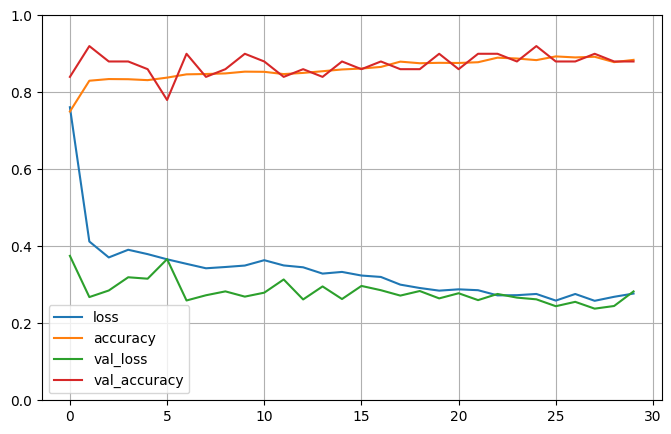

In [ ]:
#plot the model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

We see some images are classified into correct labels.

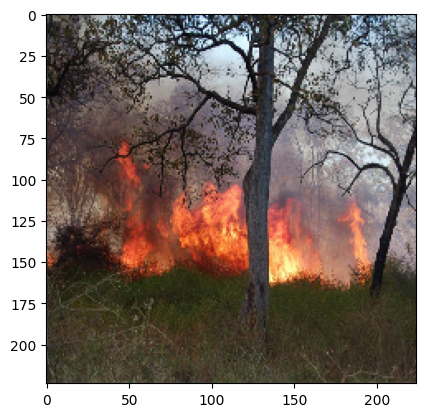

1/1 [==============================] - 0s 79ms/step
[1 1 1]
Fire


In [ ]:
#Show image and classification
X_new = X_test[:3]
plt.imshow(X_new[1], vmin=0, vmax=255)
plt.show()
y_pred = np.argmax(model.predict(X_new), axis=-1)
print(y_pred)
print(labels[y_pred[1]])

We have now fine tuned the model to reduce the vanishing/unstable gradient and overfitting problem. The ultimate goal of this was to classify the fire from images and using a simple neural network has produced good result.


# CNN

We also look into a Convolution Neural Network (CNN). This is a process was inpired by the visual cortex [1]. This introduces two new layer one being the convolution layers and the other being the pooling layers [1].

The convolution layers are the layers where the neurons are not connected to every pixel in the image [1]. Where in the first and second layers of neurons are connected by the location of the first layer neuron [1]. This location is a rectangle shape. The convolution layers are stacked with different features and filters. One feature is the RBG channel.

The pooling layers are there to shrink the image to reduce the load, this also limits the risk of overfitting [1].

Note that this is a long process it take alot of computational power and long time to process it.

Extracting the batch size, height, width and channels from the X_train dimensions makes thes processes easier.

In [ ]:
#define the variable from the X_train shape.
batch_size, height, width, channels = X_train.shape
print("batch size: {}  height: {}  width: {}  channels: {}".format(
    batch_size, height, width, channels))

batch size: 4576  height: 224  width: 224  channels: 3


Our CNN is very vanilla and basic it uses 5 layers of convultion layers, were four of the layers are stacked together as a pair. The model is Sequential like our simple neural network. The first layer is the convolution layer where we have 64 filters, a kernel size of 7 and a stride of 2 since we have a large images. We also use a "SAME" padding simple because we dont want to ignore anypart of the image, since it may contain fire. We also use a He normalisation.

The model increases in the filters from 64 to 256 and back down to 64, the kernel_size decreases to 3.
We use pooling to reduce the images every time and our max pooling is set to 2.

We then finally have our best simple neural network.

We summaries the model, compile it, fit the model and evaluate it.

In [ ]:
#A CNN model is defined

#repeated variable defined
DefaultConv2D = partial(
    keras.layers.Conv2D,
    kernel_size=3,
    strides=2,
    padding="same",
    activation="relu",
    kernel_initializer="he_normal",
    )

#model is built
model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[224, 224,3]),
    keras.layers.MaxPooling2D(2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128, kernel_size=3),
    keras.layers.MaxPooling2D(2),
    DefaultConv2D(filters=256, kernel_size=3),
    DefaultConv2D(filters=256, kernel_size=3),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu",kernel_initializer="he_normal",
                      kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(64, activation="relu",kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(2, activation="sigmoid")
])
#summary of the model
model.summary()

#compile the model
model.compile(loss= keras.losses.SparseCategoricalCrossentropy(),
              optimizer = keras.optimizers.SGD(learning_rate=1e-3,
                                                momentum=0.9),
              metrics=["accuracy"])
#fit the model
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

#evaluate the model
mse_test = model.evaluate(X_test, y_test)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)        

This CNN produced a loss of 83.1 and a accuracy of 0.92 this shows that with the CNN we have only slighly increased the evaulation of the model. But we have reached the accuracy of 0.92
Looking at the validation losses and accuracy this seems to be more stable than the simple Neural network.

The graph below shows the stability in our CNN and a small fluctaution nearing the end which shows the unstable gradient problem which is inherit in all neural networks.

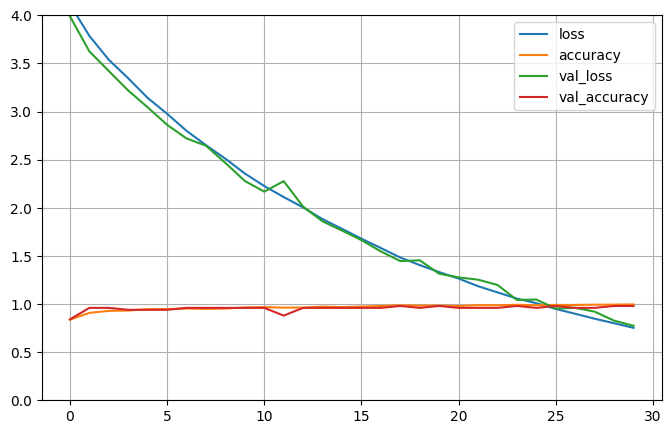

In [ ]:
#plot the model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 4)
plt.show()

The image produced shows us that we correctly classified the fire in the images.

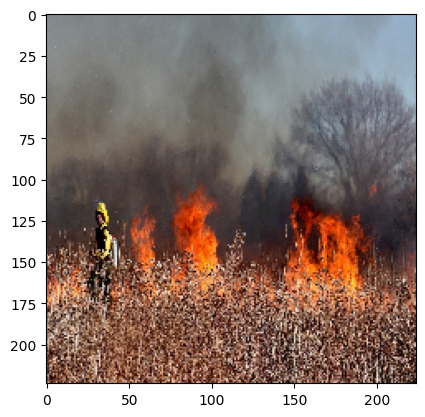

1/1 [==============================] - 0s 110ms/step
[1 1 1]
Fire


In [ ]:
#show image and classification
X_new = X_test[:3]
plt.imshow(X_new[0], vmin=0, vmax=255)
plt.show()
y_pred = np.argmax(model.predict(X_new), axis=-1)
print(y_pred)
print(labels[y_pred[0]])

# Transfer Learning

Since CNN are very time consuming and has a large computaional load, we would use a pretrained models from Keras such as the ResNet 50.

We revert the image back to its original pixel intesity,
then use the layers from the ResNet50 base. The average pool is the global average pooling. The output uses sigmoid activation and then we create our model. Then we freeze the layers for a few training loops to freeze the weights. We also drop the learning rates.

We compile and fit our model, then proceed to unfreeze the weights and compile and fit our model again and then later evaluate it.


In [ ]:
#the ResNet 50 is called with the shape input
base = keras.applications.resnet50.ResNet50(weights="imagenet",
                                             include_top=False,
                                            input_shape=(224, 224,3))


#we scale the images back to 255

X_train_new = keras.applications.resnet50.preprocess_input(X_train*255)

base_layers = base.output
avg_pool = keras.layers.GlobalAveragePooling2D()(base_layers)
output = keras.layers.Dense(2, activation="sigmoid")(avg_pool)
model = keras.Model(inputs=base.input, outputs=output)

#freeze layer
for layer in model.layers:
    layer.trainable = False

#compile model
model.compile(loss= keras.losses.SparseCategoricalCrossentropy(),
              optimizer = keras.optimizers.SGD(learning_rate=2e-2,
                                                     momentum=0.9),
              metrics=["accuracy"])

#fit the model
history = model.fit(X_train_new, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))

#Unfreeze layer
for layer in model.layers:
    layer.trainable = True

model.compile(loss= keras.losses.SparseCategoricalCrossentropy(),
              optimizer = keras.optimizers.SGD(learning_rate=1e-3,
                                                     momentum=0.9),
              metrics=["accuracy"])

#fit the model
history = model.fit(X_train_new, y_train, epochs=15,
                    validation_data=(X_valid, y_valid))


#Evaluate model
mse_test = model.evaluate(X_test, y_test)


The ResNet50 pretrained layers have very low loss at 0.89 and an accuracy of 0.74 meaning that the model has very small errors in between the actual and the predicted. The validation set shows us that the loss is also very small but the accuracy of that set is the same.

The image below was falsely identified.

In [ ]:
#Image and classification
X_new = X_test[:3]
plt.imshow(X_new[1], vmin=0, vmax=255)
plt.show()
y_pred = np.argmax(model.predict(X_new), axis=-1)
print(y_pred)
print(labels[y_pred[1]])

# Discussion


The main aspect of this report was to identify fire in the images. This was done by classifying images that had fire or not.

We started of with a simple neural network with two layers both containing 300 neurons. This was evaluated with a loss of 115.2 and an accuracy of 0.84. This was an already strong start and a good place to fine tune the model.
This was done choosing the best optimizer and loss function.

We saw that in the training data the loss was decreasing and the accuracy was increasing steadily, however in regards to the validation data, the loss and the accuracy were either flucuating or they were stagnant.

This indicated that there is a vanishing/unstable gradient problem. This has caused us to use normalisartion techiques like He-normalisation. This produced a lower loss value but also lower accuracy value. We also use other techiques such as Batch normalisation which had a made the validation data even more unstable. Gradient clipping was also looked at but it didnt have much effect.

The next step was to tackle the overfitting problem, this lead us to use the L2 regularisation and Dropout methods. This lowered the loss again and also the accuracy decreased slightly. L2 regularisation was prefered.

Finally after fine tuning the model and adding normalisations and regularisations  we have a model with a loss between 80 to 100  and an accuracy of 0.80 to 0.84, the range is there depending on the model changes.

We then implemented a CNN and a pretrained transfer learning with ResNet 50.
The CNN had a loss of 83.1 and an accuracy of 0.92 which is one of the best model interms of both the losses and the accuracy of the model.

The ResNet50 had a loss of 0.89 which is very small compared to the simple neural network we produced earlier. However the accuracy of the model is 0.74, this could be improved with further development in our part. Which shows promising signs that we can create a model with a higher accuracy.


The are some limitations within this report which are the time consuming and GPU needed this limited the flexibility in changing parameters, this caused alot of crashes.
Other limitations are the trade of the loss function and the accuracy as you would like to produce models that have low losses and high accuracy and with this the highest accuracy came with the CNN model but this had high loss compared to the ResNet50.
The choosing of the best optimizer was also difficult since sometimes when your run the model other optimizers such as AdaGrad and RMSprop produced the least losses but with very low accuary ranging from 0.5 to 0.7.

This report in total we began with a simple model with a high accuracy and high loss and we ended up with a CNN with a lower loss and a higher accuracy performance.

# Conclusion


Final thoughts are that  the three types of Deep learning models used had varying results but all could successfully classify fire in the images. Using the simple neural network we were able to identify overfitting and vanishing/unstable gradient problem and solve them to a reasonable degree using different approaches.

For the CNN we added extra layers to our simple neural network and produced an improvement of the exisiting model

ResNet was pretrained and used a transfer learning, this produced a model with a very low loss but a low accuracy.

In conclusion, the CNN models is the best model in classifing fire from images, this could help enviromental challenges in identifying area that have been affected by forrest fires and could lead to a minimizing its impact.

# References

[1] Geron, A.G, 2019, *Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow*, Last Accessed 7 July 2024